In [4]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD

import syft as sy
from syft.core.node.vm.vm import VirtualMachine
from syft.core.node.vm.client import VirtualMachineClient
from syft.ast.module import Module
from syft.core.remote_dataloader import RemoteDataLoader
from syft.core.remote_dataloader import RemoteDataset

print(f'torch version: {torch.__version__}')
print(f'syft version: {sy.__version__}')


torch version: 1.8.1+cu102
syft version: 0.5.0


## Files and Directories

In [5]:
# paths to files and directories
project_path = Path.cwd().parent
print(f'project_path: {project_path}')
data_dir = 'mitdb'
train_name = 'train_ecg.hdf5'
test_name = 'test_ecg.hdf5'
all_name = 'all_ecg.hdf5'
model_dir = 'model'
model_name = 'conv2'
model_ext = '.pth'
csv_dir = 'csv'
csv_ext = '.csv'
csv_name = 'conv2'
csv_accs_name = 'accs_conv2'

project_path: /mnt/batch/tasks/shared/LS_root/mounts/clusters/teslak80-56gbram/code/Users/dkn.work/split-learning-he


## Construct the client and server

In [6]:
server: VirtualMachine = sy.VirtualMachine(name="server")
client: VirtualMachineClient = server.get_root_client()

In [7]:
remote_torch: Module = client.torch
remote_torch

Module:
	.Tensor -> <syft.ast.klass.Class object at 0x7fe85acf3b80>
	.BFloat16Tensor -> <syft.ast.klass.Class object at 0x7fe85b85f040>
	.BoolTensor -> <syft.ast.klass.Class object at 0x7fe85acf3a60>
	.ByteTensor -> <syft.ast.klass.Class object at 0x7fe85acf3be0>
	.CharTensor -> <syft.ast.klass.Class object at 0x7fe85acf3c40>
	.DoubleTensor -> <syft.ast.klass.Class object at 0x7fe85acf3ca0>
	.FloatTensor -> <syft.ast.klass.Class object at 0x7fe85acf3d00>
	.HalfTensor -> <syft.ast.klass.Class object at 0x7fe85acf3d60>
	.IntTensor -> <syft.ast.klass.Class object at 0x7fe85acf3dc0>
	.LongTensor -> <syft.ast.klass.Class object at 0x7fe85acf3e20>
	.ShortTensor -> <syft.ast.klass.Class object at 0x7fe85acf3e80>
	.nn -> Module:
		.Parameter -> <syft.ast.klass.Class object at 0x7fe85acf3fa0>
		.Module -> <syft.ast.klass.Class object at 0x7fe85ac3b4c0>
		.Conv2d -> <syft.ast.klass.Class object at 0x7fe85ac3b9a0>
		.Dropout2d -> <syft.ast.klass.Class object at 0x7fe85ac3bdc0>
		.Linear -> <syft.

## Client: loading and exploring the dataset

In [9]:
class ECG(Dataset):
    # The class used to load the ECG dataset
    def __init__(self, mode='train'):
        if mode == 'train':
            with h5py.File(project_path/data_dir/train_name, 'r') as hdf:
                self.x = hdf['x_train'][:]
                self.y = hdf['y_train'][:]
        elif mode == 'test':
            with h5py.File(project_path/data_dir/test_name, 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]
        else:
            raise ValueError('Argument of mode should be train or test')
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

In [10]:
train_dataset = ECG(mode='train')
test_dataset = ECG(mode='test')

In [7]:
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))
print(f'x_train: {type(x_train)}, {x_train.size()}')
print(f'y_train: {type(y_train)}, {y_train.size()}')
print(f'x_test: {type(x_test)}, {x_test.size()}')
print(f'y_test: {type(y_test)}, {y_test.size()}')

x_train: <class 'torch.Tensor'>, torch.Size([13245, 1, 128])
y_train: <class 'torch.Tensor'>, torch.Size([13245])
x_test: <class 'torch.Tensor'>, torch.Size([13245, 1, 128])
y_test: <class 'torch.Tensor'>, torch.Size([13245])


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

x_0: torch.Size([1, 128])
unrolling: torch.Size([128])


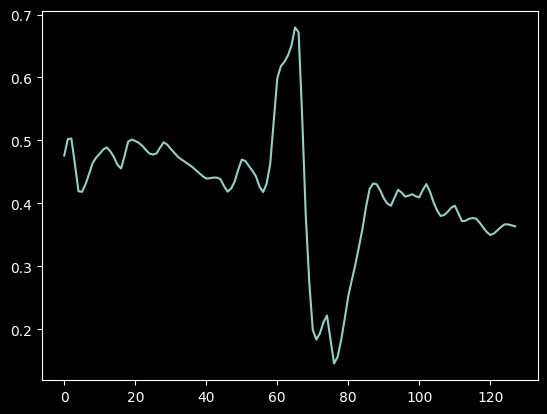

In [9]:
x0 = x_train[0, :, :]
print(f'x_0: {x0.shape}')
x0_unroll = x0.view(-1)
print(f'unrolling: {x0_unroll.shape}')
indx = np.arange(0, 128)

# plt.figure(figsize=(3,3))
plt.style.use('dark_background')
plt.plot(indx, x0_unroll)
plt.show()

## Server: point to the dataset using `remote_torch`

In [10]:
x_train_ptr = remote_torch.Tensor(x_train)
y_train_ptr = remote_torch.LongTensor(y_train)
x_test_ptr = remote_torch.Tensor(x_test)
y_test_ptr = remote_torch.LongTensor(y_test)

In [11]:
x_train_ptr

In [12]:
remote_torch.utils.data.DataLoader(train_dataset)

AttributeError: 'ECG' object has no attribute 'send'

In [12]:
batch_size = 1  # used for training
xdl_ptr = remote_torch.utils.data.DataLoader(x_train_ptr, batch_size=batch_size)
ydl_ptr = remote_torch.utils.data.DataLoader(y_train_ptr, batch_size=batch_size)
xtdl_ptr = remote_torch.utils.data.DataLoader(x_test_ptr, batch_size=batch_size)
ytdl_ptr = remote_torch.utils.data.DataLoader(y_test_ptr, batch_size=batch_size)

In [13]:
xdl_ptr

In [14]:
inputs_ptr = next(iter(xdl_ptr))

In [15]:
ii = inputs_ptr.get_copy()

In [16]:
i3 = next(iter(xdl_ptr))
i3 = i3.get_copy()

## Server: define the spit neural network used to train on the ECG dataset

Client's side contains conv layers

In [17]:
class EcgClient(sy.Module):
    # used by the data owners
    def __init__(self, torch_ref):
        super(EcgClient, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv1d(1, 16, 7, padding=3)  # 128 x 16
        self.relu1 = self.torch_ref.nn.LeakyReLU()
        self.pool1 = self.torch_ref.nn.MaxPool1d(2)  # 64 x 16
        self.conv2 = self.torch_ref.nn.Conv1d(16, 16, 5, padding=2)  # 64 x 16
        self.relu2 = self.torch_ref.nn.LeakyReLU()
        self.pool2 = self.torch_ref.nn.MaxPool1d(2)  # 32 x 16
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.view(-1, 32 * 16)
        return x

Server's side contains fully connected layers

In [18]:
class EcgServer(sy.Module):
    def __init__(self, torch_ref):
        super(EcgServer, self).__init__(torch_ref=torch_ref)
        self.linear3 = nn.Linear(32 * 16, 128)
        self.relu3 = nn.LeakyReLU() 
        self.linear4 = nn.Linear(128, 5)
        self.softmax4 = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.softmax4(x)
        return x

## Server: training process

In [19]:
ecg_client = EcgClient(torch_ref=torch)
checkpoint = torch.load("init_weight.pth")
ecg_client.conv1.weight.data = checkpoint["conv1.weight"]
ecg_client.conv1.bias.data = checkpoint["conv1.bias"]
ecg_client.conv2.weight.data = checkpoint["conv2.weight"]
ecg_client.conv2.bias.data = checkpoint["conv2.bias"]

ecg_server = EcgServer(torch_ref=torch)
checkpoint = torch.load("init_weight.pth")
ecg_server.linear3.weight.data = checkpoint["linear3.weight"]
ecg_server.linear3.bias.data = checkpoint["linear3.bias"]
ecg_server.linear4.weight.data = checkpoint["linear4.weight"]
ecg_server.linear4.bias.data = checkpoint["linear4.bias"]

# Send the client's model to the client
ecg_client_ptr = ecg_client.send(client)

In [20]:
total_batch = 414  # 32*414=13248. We have 13245 data samples

epoch = 400
criterion = nn.CrossEntropyLoss()
lr = 0.001

optim_client = remote_torch.optim.Adam(params=ecg_client_ptr.parameters(), lr=lr)
optim_server = torch.optim.Adam(params=ecg_server.parameters(), lr=lr)

### Training (with CPU)

In [21]:
ecg_client = EcgClient(torch_ref=torch)
checkpoint = torch.load("init_weight.pth")
ecg_client.conv1.weight.data = checkpoint["conv1.weight"]
ecg_client.conv1.bias.data = checkpoint["conv1.bias"]
ecg_client.conv2.weight.data = checkpoint["conv2.weight"]
ecg_client.conv2.bias.data = checkpoint["conv2.bias"]

ecg_server = EcgServer(torch_ref=torch)
checkpoint = torch.load("init_weight.pth")
ecg_server.linear3.weight.data = checkpoint["linear3.weight"]
ecg_server.linear3.bias.data = checkpoint["linear3.bias"]
ecg_server.linear4.weight.data = checkpoint["linear4.weight"]
ecg_server.linear4.bias.data = checkpoint["linear4.bias"]

# Send the client's model to the client
ecg_client_ptr = ecg_client.send(client)

In [22]:
from tqdm import tqdm

train_losses = list()
train_accs = list()
test_losses = list()
test_accs = list()
best_test_acc = 0  # best test accuracy
for e in range(10):
    print(f"Epoch {e+1} - train ", end='')
    
    train_loss = 0.0
    correct, total = 0, 0
    for i in tqdm(range(10)):
        # get the next batch's data
        inputs_ptr = next(iter(xdl_ptr))
        gt_ptr = next(iter(ydl_ptr))
        print(gt_ptr.get_copy())
        # inputs_ptr = to_cuda_client(client_bool_cuda, inputs_ptr)
        # initialize all gradients to zero
        optim_server.zero_grad()
        optim_client.zero_grad()
        # compute and get the activation signals from the first half of the network
        activs_ptr = ecg_client_ptr(inputs_ptr)
        # the server still gets access to plain activation signals
        activs = activs_ptr.clone().get(request_block=True)
        # print(activs)
        # the server continues the forward pass on the activation maps
        y_hat = ecg_server(activs)
        # the server asks to access ground truths in plain text, then put on GPU
        y_gt = gt_ptr.get_copy()
        # calculates cross-entropy loss
        loss = criterion(y_hat, y_gt)
        train_loss += loss.item()
        correct += torch.sum(y_hat.argmax(dim=1) == y_gt).item()
        # backward propagation (calculating gradients of the loss w.r.t the weights)
        loss.backward()
        # send the gradients to the client
        client_grad_ptr = activs.grad.clone().send(client)
        # update the gradients of the client's model
        activs_ptr.backward(client_grad_ptr)
        # update the weights based on the gradients
        optim_client.step()
        optim_server.step()
        total += len(y_gt)

    train_losses.append(train_loss / total_batch)
    train_accs.append(correct / total)

    print(f'loss: {train_losses[-1]: .4f}, accuracy: {train_accs[-1]*100: 2f}')

Epoch 1 - train tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
loss:  0.0390, accuracy:  0.000000
Epoch 2 - train tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
loss:  0.0390, accuracy:  0.000000
Epoch 3 - train tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
loss:  0.0390, accuracy:  0.000000
Epoch 4 - train tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
loss:  0.0390, accuracy:  0.000000
Epoch 5 - train tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])


  0%|          | 0/10 [00:00<?, ?it/s]/anaconda/envs/SyftEnv2/lib/python3.9/site-packages/syft/lib/torch/uppercase_tensor.py:30: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  grad = getattr(obj, "grad", None)
 60%|██████    | 6/10 [00:02<00:01,  2.41it/s]


KeyboardInterrupt: 